In [53]:
# Read all the text book
words = open('constitution.txt', 'r').read().split()
len(words)

132548

In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# Build a voculabory of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
len(chars)

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['~']= 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'vocab_size ; {vocab_size}  |\n stoi: {stoi}  | \n  itos: {itos}')
# assert '~' in stoi.items().key()
# chars

vocab_size ; 87  |
 stoi: {'"': 1, '&': 2, "'": 3, '(': 4, ')': 5, '*': 6, ',': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, ';': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, '[': 49, ']': 50, '_': 51, 'a': 52, 'b': 53, 'c': 54, 'd': 55, 'e': 56, 'f': 57, 'g': 58, 'h': 59, 'i': 60, 'j': 61, 'k': 62, 'l': 63, 'm': 64, 'n': 65, 'o': 66, 'p': 67, 'q': 68, 'r': 69, 's': 70, 't': 71, 'u': 72, 'v': 73, 'w': 74, 'x': 75, 'y': 76, 'z': 77, '–': 78, '—': 79, '―': 80, '‘': 81, '’': 82, '“': 83, '”': 84, '…': 85, '\uf02a': 86, '~': 0}  | 
  itos: {1: '"', 2: '&', 3: "'", 4: '(', 5: ')', 6: '*', 7: ',', 8: '-', 9: '.', 10: '/', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
device

device(type='cuda')

In [136]:
#build the dataset
block_size = 8  # context length

def build_datasets(words):    
    X,Y =[],[]
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '~':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix]
    # stoi['~']
    # itos
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(f'X.shape : {X.shape} | Y.shape : {Y.shape}')
    return X,Y


import random
random.seed(42)
# random.shuffle(words) no shuffler required. Hence commented
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(f'total words : {len(words)} | training size  : {n1}  | validation size  : {n2}')
Xtr, Ytr = build_datasets(words[:n1])
Xv, Yv  = build_datasets(words[n1:n2])
Xte, Yt = build_datasets(words[n2:])


total words : 132548 | training size  : 106038  | validation size  : 119293
X.shape : torch.Size([643330, 10]) | Y.shape : torch.Size([643330])
X.shape : torch.Size([83150, 10]) | Y.shape : torch.Size([83150])
X.shape : torch.Size([83197, 10]) | Y.shape : torch.Size([83197])


In [167]:
#mlp revisited
n_embd = 10  # The dimensions of the character embeding vectors
n_hidden = 200 # No of neuron in hidden layer of the MLP    
# g = torch.Generator.manual_seed(42) # for cpu prcessing
g = torch.cuda.manual_seed(42) # for Gpu prcessing
C = torch.randn((vocab_size,n_embd),device=device,                        generator=g)
W1 = torch.randn((n_embd* block_size, n_hidden ),device=device,           generator=g) * (5/3)/((n_embd * block_size)**0.5)  #https://pytorch.org/docs/stable/nn.init.html 
b1 = torch.randn(n_hidden,device=device,                                  generator=g) *  0.01
W2 = torch.randn((n_hidden, vocab_size),device=device,                    generator=g) * 0.01
b2 = torch.randn(vocab_size,device=device,                                generator=g) * 0

bngain = torch.ones((1, n_hidden), device=device)
bnbias = torch.zeros((1, n_hidden), device=device)
bnmean_running = torch.zeros((1,n_hidden), device=device)
bnstd_running = torch.ones((1, n_hidden), device=device)

parameters = [C,W1,b2,W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters )) # No of parameter in total
for p in parameters:
    p.requires_grad = True

38844


In [168]:
## optimization steps
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]  # batch X,Y
    
    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatinate the vectors
    hpreact = embcat @ W1  # +b1  # hidden layers preactivations
    
    # BatchNorm Layer  -----------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias  #https://arxiv.org/abs/1502.03167  # batch normalisation
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------------------------------------------------------------
    ## Non linearity
    h = torch.tanh(hpreact) ## hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update weight
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}  : {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000  : 4.4685
  10000/ 200000  : 1.9621
  20000/ 200000  : 1.5060
  30000/ 200000  : 1.4059
  40000/ 200000  : 1.6520
  50000/ 200000  : 1.1795
  60000/ 200000  : 1.7614
  70000/ 200000  : 1.1408
  80000/ 200000  : 1.4487
  90000/ 200000  : 1.3213
 100000/ 200000  : 1.3370
 110000/ 200000  : 1.2491
 120000/ 200000  : 1.4901
 130000/ 200000  : 1.0573
 140000/ 200000  : 1.1773
 150000/ 200000  : 1.3466
 160000/ 200000  : 1.5978
 170000/ 200000  : 1.9733
 180000/ 200000  : 0.8236
 190000/ 200000  : 1.2360


(array([1046.,  257.,  202.,  142.,  153.,  110.,  105.,  102.,   94.,
          52.,   73.,   58.,   66.,   58.,   71.,   70.,   55.,   50.,
          63.,   61.,   61.,   64.,   52.,   57.,   43.,   42.,   59.,
          56.,   47.,   65.,   58.,   27.,   62.,   67.,   35.,   79.,
          73.,   91.,   55.,   91.,   79.,  115.,  104.,  116.,   81.,
         146.,  136.,  198.,  317., 1036.]),
 array([-9.99999940e-01, -9.59999942e-01, -9.19999943e-01, -8.79999944e-01,
        -8.39999945e-01, -7.99999946e-01, -7.59999948e-01, -7.19999949e-01,
        -6.79999950e-01, -6.39999951e-01, -5.99999952e-01, -5.59999954e-01,
        -5.19999955e-01, -4.79999956e-01, -4.39999957e-01, -3.99999958e-01,
        -3.59999959e-01, -3.19999961e-01, -2.79999962e-01, -2.39999963e-01,
        -1.99999964e-01, -1.59999965e-01, -1.19999967e-01, -7.99999678e-02,
        -3.99999690e-02,  2.98023224e-08,  4.00000286e-02,  8.00000274e-02,
         1.20000026e-01,  1.60000025e-01,  2.00000024e-01,  2.400000

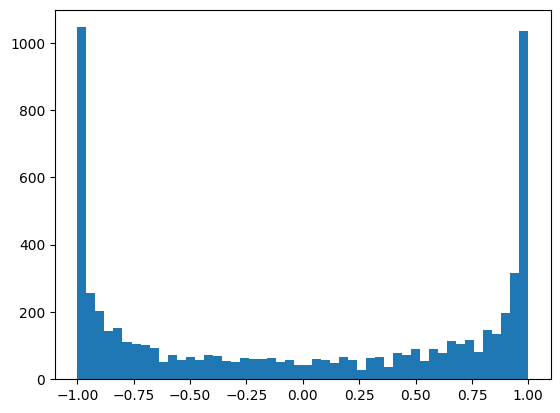

In [157]:
h_cpu = h.cpu()
h_cpu.device
plt.hist(h_cpu.view(-1).tolist(), 50)

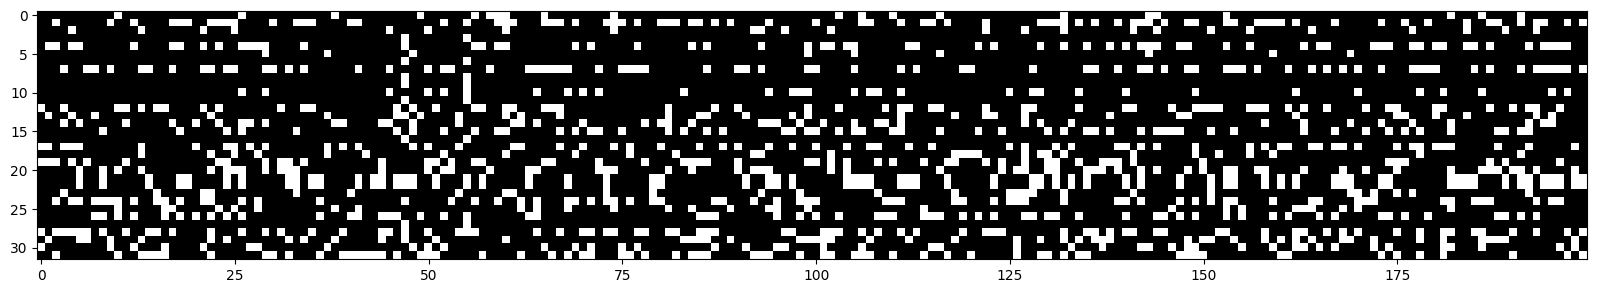

In [158]:
plt.figure(figsize=(20,10))
plt.imshow(h_cpu.abs()> 0.99, cmap='gray', interpolation='nearest')

In [159]:
# Experimenting with initialiuzng
# gain/ fan_in **0.5
(torch.randn(10000)*0.2).std()

tensor(0.2029)

(array([  1.,   2.,   4.,   1.,   5.,  11.,  12.,  24.,  22.,  29.,  35.,
         55.,  58.,  81., 101., 133., 158., 182., 266., 290., 360., 405.,
        427., 486., 433., 482., 466., 334., 317., 290., 221., 133., 123.,
        122.,  84.,  51.,  47.,  35.,  30.,  23.,  18.,  11.,  11.,   8.,
          4.,   3.,   3.,   2.,   0.,   1.]),
 array([-8.47451687, -8.12218466, -7.76985245, -7.41752024, -7.06518803,
        -6.71285582, -6.36052361, -6.00819139, -5.65585918, -5.30352697,
        -4.95119476, -4.59886255, -4.24653034, -3.89419813, -3.54186592,
        -3.18953371, -2.8372015 , -2.48486929, -2.13253708, -1.78020487,
        -1.42787266, -1.07554045, -0.72320824, -0.37087603, -0.01854382,
         0.33378839,  0.68612061,  1.03845282,  1.39078503,  1.74311724,
         2.09544945,  2.44778166,  2.80011387,  3.15244608,  3.50477829,
         3.8571105 ,  4.20944271,  4.56177492,  4.91410713,  5.26643934,
         5.61877155,  5.97110376,  6.32343597,  6.67576818,  7.0281004 ,
 

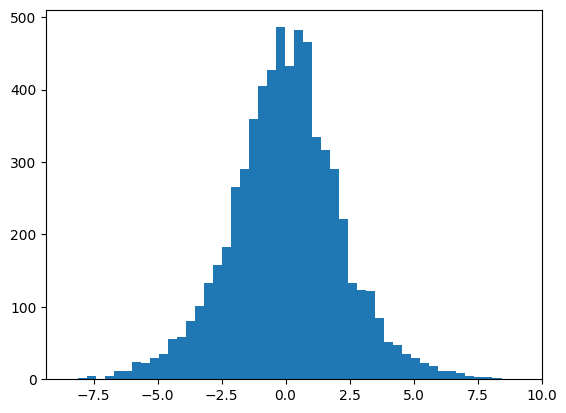

In [160]:
hpreact_c =  hpreact.cpu()
plt.hist(hpreact_c.view(-1).tolist(), 50)

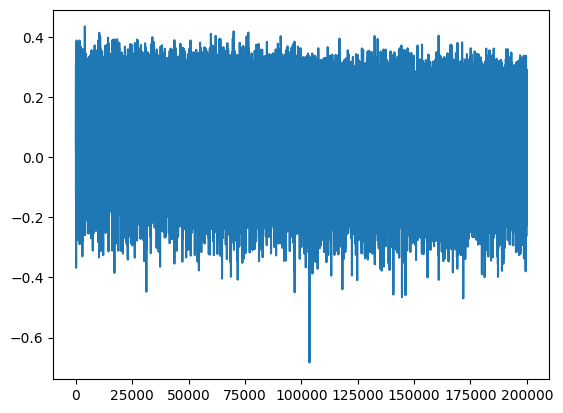

In [161]:
plt.plot(lossi)

In [162]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x,y  = {
        'train' : (Xtr,Ytr),
        'val' : (Xv,Yv),
        'text' : (Xte, Yt),
    }[split]
    emb = C[x] # (N,block_size , n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    hpreact = embcat @ W1 +b1  # hidden layers preactivations
    hpreact = bngain* (hpreact - hpreact.mean(0, keepdim=True))/ hpreact.std(0, keepdim=True) + bnbias  #https://arxiv.org/abs/1502.03167  # batch normalisation
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 +b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.1460453271865845
val 1.3640717267990112


In [163]:
# Sample from the model
g = torch.cuda.manual_seed(52)

for _ in range(20):
    out = []
    context = [0] * block_size  # init with Zero
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs= F.softmax(logits, dim=1)
        #sample from the distributions
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out ))  # decode and porint the generated word

exestiditnces~
zivel~
imicaireal~
willances~
imitusitelshtiouldren~
Tptaksoubliollanysparatender~
gikkkinrengessome-tyibq~
imgadar~
existivalite,~
iguzhty;~
imkencelilge~
inkengenditurallers~
imgiluntalitlational~
Foukdomunitotated~
beitururettiviey~
inkaltoul~
endeaks.-entendeneg~
iilskritsolterttyendy~
ulden~
quninthen~
